
# <div style="text-align: center"> CS984 - Introduction to Hardware Security </div> 

##### <div style="text-align: right"> Assignment - 1  </div>  

##### <div style="text-align: right"> Roll No: 233560040  </div>  

##### <div style="text-align: right"> emailId: vinayaks23@iitk.ac.in  </div>   

## Problem Statement.

Daniel is a security engineer, and he has a got a project for side-channel analysis of
an AES hardware implementation. He has already collected power traces for that
AES implementation with a 128-bit key ‘K’ and have stored the traces in
“traces_AES.csv” file. The first column in the csv file indicates the plaintext, the
second column indicates the ciphertext and rest of the columns indicates the
sample points. Now Daniel has to analyse the power traces and will have to find the
AES key using Correlation Power Analysis (CPA). Help Daniel to perform the CPA
attack.

### Given: 

The `traces_AES.csv` file contains three columns: **Plaintext**, **Ciphertext**, and **Traces**. This file represents actual power trace data collected from a power analysis experiment conducted on a chip. Each row corresponds to power trace measurements for 10 rounds of AES encryption associated with a specific plaintext-ciphertext pair.


### Expectation:

We have to help Daniel in analysing the power traces from the traces_AES.csv file and recover the entire AES key using Correlation Power Analysis (CPA) attack.

# Correlation Power Analysis (CPA).

Like in the DoM based DPA attack, the Correlation Power Attack (CPA) also relies on targeting an intermediate computation, typically the input or output of an S-Box. These intermediate values are as seen previously computed from a known value, typically the ciphertext and a portion of the key, which is guessed. The power model is subsequently used to develop a hypothetical power trace of the device for a given input to the cipher. This hypothetical power values are then stored in a matrix for several inputs and can be indexed by the known value of the ciphertext or the guessed key byte. This matrix is denoted as H, the hypothetical power matrix. Along with this, the attacker also observes the actual power traces, and stores them in a matrix for several inputs. The actual power values can be indexed by the known value of the ciphertext and the time instance when the power value was observed. This matrix is denoted as T, the real power matrix. It may be observed that one of the columns of the matrix H corresponds to the actual key, denoted as kc. In order to distinguish the key from the others, the attacker looks for similarity between the columns of the matrix H and those of the matrix T. The similarity is typically computed
using the Pearson’s Correlation coeﬃcient as defined in formula below. 



$$""result[i][j] = \frac{\sum_{k=0}^{N_{Sample}} (hPower[i][k] - meanH[i])(trace[j][k] - meanTrace[j])}{\sqrt{\sum_{k=0}^{N_{Sample}} (hPower[i][k] - meanH[i])^2 \sum_{k=0}^{N_{Sample}} (trace[j][k] - meanTrace[j])^2}}$$

or Simplified as 

$$r = \frac{n \sum xy - (\sum x)(\sum y)}{\sqrt{[n \sum x^2 - (\sum x)^2][n \sum y^2 - (\sum y)^2]}}$$

# Analysis of Trace data.

The dataset contains 30,000 rows and 152 columns, with two columns containing plaintext and ciphertext, and the remaining columns containing traces of power consumption.

The values in the Traces column are as follows:

[383, 384, 382, 381, 385, 371, 370, 372, 380, 369, 373, 379, 368, 374, 386, 367, 376, 378, 377, 375, 366, 360, 361, 365, 364, 359, 363, 362, 387, 358, 388, 357, 356, 389, 355, 390, 354, 391, 353, 352, 392, 351, 393, 350, 349, 348, 394, 395, 346, 344]

The remaining columns, except for Plaintext and Ciphertext, contain integer values representing power consumption traces.

In [1]:
import pandas as pd
import numpy as np
from scipy.stats import pearsonr
from numpy import unravel_index

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

df = pd.read_csv('traces_AES.csv')

print(df.head().to_markdown(index=False, numalign="left", stralign="left"))

print(df.info())

| Plaintext                        | Ciphertext                       | Traces   | Unnamed: 3   | Unnamed: 4   | Unnamed: 5   | Unnamed: 6   | Unnamed: 7   | Unnamed: 8   | Unnamed: 9   | Unnamed: 10   | Unnamed: 11   | Unnamed: 12   | Unnamed: 13   | Unnamed: 14   | Unnamed: 15   | Unnamed: 16   | Unnamed: 17   | Unnamed: 18   | Unnamed: 19   | Unnamed: 20   | Unnamed: 21   | Unnamed: 22   | Unnamed: 23   | Unnamed: 24   | Unnamed: 25   | Unnamed: 26   | Unnamed: 27   | Unnamed: 28   | Unnamed: 29   | Unnamed: 30   | Unnamed: 31   | Unnamed: 32   | Unnamed: 33   | Unnamed: 34   | Unnamed: 35   | Unnamed: 36   | Unnamed: 37   | Unnamed: 38   | Unnamed: 39   | Unnamed: 40   | Unnamed: 41   | Unnamed: 42   | Unnamed: 43   | Unnamed: 44   | Unnamed: 45   | Unnamed: 46   | Unnamed: 47   | Unnamed: 48   | Unnamed: 49   | Unnamed: 50   | Unnamed: 51   | Unnamed: 52   | Unnamed: 53   | Unnamed: 54   | Unnamed: 55   | Unnamed: 56   | Unnamed: 57   | Unnamed: 58   | Unnamed: 59   | Unnamed: 60 

### Extract Columns

The columns **traces** , **Ciphertext** and **Plaintext** are extracted in the following code. Unfortunately in the csv file the 0x0 is just a single character we need to format it to take 128bits. Hence we use the function ***plaintextformat*** as shown below

```python 
def plaintextformat(plaintext):
    if plaintext == '0':
        return '00000000000000000000000000000000'
    else:
        return plaintext
```        

In [2]:
traces = df.iloc[1:, 2:].values
traces

array([[389, 252, 208, ..., 264, 285, 292],
       [376, 255, 213, ..., 301, 278, 276],
       [386, 252, 202, ..., 281, 315, 307],
       ...,
       [367, 296, 211, ..., 290, 258, 268],
       [372, 300, 213, ..., 323, 296, 294],
       [387, 294, 205, ..., 278, 285, 283]], shape=(29999, 150))

In [3]:
def plaintextformat(plaintext):
    if plaintext == '0':
        return '00000000000000000000000000000000'
    else:
        return plaintext
    
plaintexts = df.iloc[:, 0].values
formattedplaintext = np.array([plaintextformat(pt) for pt in plaintexts],dtype=object)
formattedplaintext

array(['00000000000000000000000000000000',
       '7df76b0c1ab899b33e42f047b91b546f',
       'a9dcf5aa138056e259e7be57958e72d8', ...,
       '2fe99af02c983246ff228ced17239b24',
       '96acd213cd6ac463b3be6859d725f6c6',
       '80c87c1dc35a8b945f9e9f6d5f1db1d1'], shape=(30000,), dtype=object)

In [4]:
ciphertexts = df.iloc[:, 1].values
ciphertexts

array(['7df76b0c1ab899b33e42f047b91b546f',
       'a9dcf5aa138056e259e7be57958e72d8',
       '626caecce6b25a25524cb32b7ec1374e', ...,
       '96acd213cd6ac463b3be6859d725f6c6',
       '80c87c1dc35a8b945f9e9f6d5f1db1d1',
       'e35457b42cc2c384f5b40dc80312cd71'], shape=(30000,), dtype=object)

Now that we have the columns extracted we define the helper Objects and functions.

In [5]:
NSample,NPoint= np.shape(traces)
NSample,NPoint

(29999, 150)

## Computing Correlation Coeﬃcient for Simulated Power Traces for AES

To analyze the power consumption of an AES implementation, we simulate its behavior, employing the Hamming Weight model for this example. We collect a set of real power measurements, stored as `trace[NSample][NPoint]`, where `NSample` represents the number of encryption operations and `NPoint` denotes the timing points of interest. In recorded data traces_AES.csv, `NPoint` is 150.

To create hypothetical power consumption data, the attacker focuses on the final round (Round 10) of AES. The attacker aims to recover a specific key byte. To do this, they need to predict the power consumption based on a guess of that key byte and the known ciphertext.

The process involves analyzing the transitions that occur in the AES registers during Round 10. Due to the ShiftRows operation within AES, the Hamming Weight calculations must account for the byte reordering. For example, to estimate the power consumption associated with the change in register R1, the attacker needs to compute the Hamming Weight between the state of R1 before and after the final round's SubBytes and key addition.

Specifically, the attacker targets a key byte (e.g., `k5`). They know the corresponding ciphertext byte (e.g., `C5`). To calculate the hypothetical power consumption, they perform the following steps:

1.  **Key Guess:** The attacker guesses a value for the key byte `k5`.
2.  **Ciphertext Manipulation:** They XOR the guessed key byte `k5` with the corresponding ciphertext byte `C5`, creating `SCipher`.
3.  **Inverse SubBytes:** They apply the Inverse SubBytes operation to the result (`InverseSBOX[SCipher]`). This step reverses part of the final round transformation, yielding an approximation of the state before the final SubBytes.
4.  **Hamming Weight Calculation:** They compute the Hamming Weight of the result of XOR between ShiftRow byte and the result of the Inverse SubBytes operation. This Hamming Weight represents the predicted power consumption related to the state transition.
5.  **Correlation Analysis:** This process is repeated for all possible values of `k5`, generating a set of hypothetical power traces. These hypothetical traces are then compared to the real power traces using correlation analysis. The key guess that yields the highest correlation coefficient is considered the most likely correct value for `k5`.

Essentially, the attacker is leveraging the known ciphertext and their key guesses to simulate the power consumption during the final round of AES. By comparing these simulations with the actual power measurements, they can statistically identify the correct key byte.


### Helper Objects and Functions

We need inverse S-Box tuple which is a tuple of hex values that make up the inverse of S-Box (SubBytes). It is defined as follows.

In [6]:
InverseSbox = (
    0x52, 0x09, 0x6A, 0xD5, 0x30, 0x36, 0xA5, 0x38, 0xBF, 0x40, 0xA3, 0x9E, 0x81, 0xF3, 0xD7, 0xFB,
    0x7C, 0xE3, 0x39, 0x82, 0x9B, 0x2F, 0xFF, 0x87, 0x34, 0x8E, 0x43, 0x44, 0xC4, 0xDE, 0xE9, 0xCB,
    0x54, 0x7B, 0x94, 0x32, 0xA6, 0xC2, 0x23, 0x3D, 0xEE, 0x4C, 0x95, 0x0B, 0x42, 0xFA, 0xC3, 0x4E,
    0x08, 0x2E, 0xA1, 0x66, 0x28, 0xD9, 0x24, 0xB2, 0x76, 0x5B, 0xA2, 0x49, 0x6D, 0x8B, 0xD1, 0x25,
    0x72, 0xF8, 0xF6, 0x64, 0x86, 0x68, 0x98, 0x16, 0xD4, 0xA4, 0x5C, 0xCC, 0x5D, 0x65, 0xB6, 0x92,
    0x6C, 0x70, 0x48, 0x50, 0xFD, 0xED, 0xB9, 0xDA, 0x5E, 0x15, 0x46, 0x57, 0xA7, 0x8D, 0x9D, 0x84,
    0x90, 0xD8, 0xAB, 0x00, 0x8C, 0xBC, 0xD3, 0x0A, 0xF7, 0xE4, 0x58, 0x05, 0xB8, 0xB3, 0x45, 0x06,
    0xD0, 0x2C, 0x1E, 0x8F, 0xCA, 0x3F, 0x0F, 0x02, 0xC1, 0xAF, 0xBD, 0x03, 0x01, 0x13, 0x8A, 0x6B,
    0x3A, 0x91, 0x11, 0x41, 0x4F, 0x67, 0xDC, 0xEA, 0x97, 0xF2, 0xCF, 0xCE, 0xF0, 0xB4, 0xE6, 0x73,
    0x96, 0xAC, 0x74, 0x22, 0xE7, 0xAD, 0x35, 0x85, 0xE2, 0xF9, 0x37, 0xE8, 0x1C, 0x75, 0xDF, 0x6E,
    0x47, 0xF1, 0x1A, 0x71, 0x1D, 0x29, 0xC5, 0x89, 0x6F, 0xB7, 0x62, 0x0E, 0xAA, 0x18, 0xBE, 0x1B,
    0xFC, 0x56, 0x3E, 0x4B, 0xC6, 0xD2, 0x79, 0x20, 0x9A, 0xDB, 0xC0, 0xFE, 0x78, 0xCD, 0x5A, 0xF4,
    0x1F, 0xDD, 0xA8, 0x33, 0x88, 0x07, 0xC7, 0x31, 0xB1, 0x12, 0x10, 0x59, 0x27, 0x80, 0xEC, 0x5F,
    0x60, 0x51, 0x7F, 0xA9, 0x19, 0xB5, 0x4A, 0x0D, 0x2D, 0xE5, 0x7A, 0x9F, 0x93, 0xC9, 0x9C, 0xEF,
    0xA0, 0xE0, 0x3B, 0x4D, 0xAE, 0x2A, 0xF5, 0xB0, 0xC8, 0xEB, 0xBB, 0x3C, 0x83, 0x53, 0x99, 0x61,
    0x17, 0x2B, 0x04, 0x7E, 0xBA, 0x77, 0xD6, 0x26, 0xE1, 0x69, 0x14, 0x63, 0x55, 0x21, 0x0C, 0x7D,
)

We also need Hamming Weight Function , which is defined in the following HW function

In [7]:
# Hamming Weight Function

def HW(x):
    return bin(x).count('1')

Let us also define the ShiftRow operation matrix as shown in the figure below which associates the positional change in the registers.

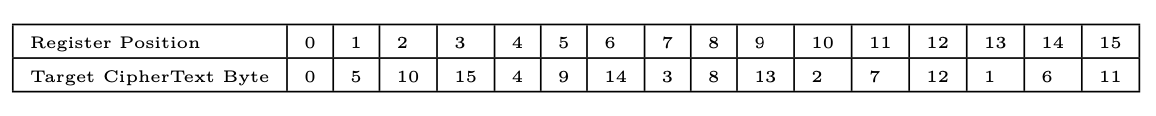

We need to define a dictonary which maps the 10th round register values to the shift row changes in the 9th round. It is defined below as follows.

In [8]:
InvSRAdj = {
        0 : 0, 
        1 : 5, 
        2 : 10, 
        3 : 15, 
        4: 4, 
        5: 9, 
        6: 14, 
        7: 3, 
        8: 8, 
        9: 13, 
        10: 2, 
        11: 7, 
        12: 12, 
        13: 1, 
        14: 6, 
        15: 11
    }

The total items (16) in this dictonary also points to our dimensions of 4*4 matrix of AES and all of the operations such as Inv SubBytes and Inv ShiftRows can be defined on this 4*4 matrix. And the entire cipher text of 128bits can be split into 4bytes into this 4*4 matrix. Each element of this matrix is a 4bytes of this cipher text. We can start looping through each element of this matrix and perform our xor with round key from 0x00 to 0xFF and take inverse SBOX and do shift row. Thus by doing this for all elements of this matrix we can create a hypothetical model by using hamming weight model. We should also loop through the NSample to retrive the ciphertexts. The idea here is to have a divide and conquer rule where we do the operations to find the HYP model byte by byte.

In [9]:
hypoModel =  np.empty([NSample, 256],dtype=np.float64)
CorrMatrix = np.empty([256, NPoint], dtype=np.float64)

for row , shiftrow in InvSRAdj.items():
    print(f"Row in process {row} and shiftRow index in consideration {shiftrow}")

    for i in range(NSample):
        for key in range(int('ff',16)+ 1):
            ciphertext = int(ciphertexts[i][row*2:(row*2)+2],16)
            #print(f"Now XORing with ciphertext {hex(ciphertext)} and Key {key}")
            xorwithkey = ciphertext ^ key
            #print(f"XOR result {hex(xorwithkey)}")
            intermediateState = int(InverseSbox[xorwithkey])
            #print(f"output of inv sbox {hex(intermediateState)}")
            outputofSR = int(ciphertexts[i][shiftrow*2:(shiftrow*2)+2],16)
            #print(f"output of SR {hex(outputofSR)}")
            SRxorSB = outputofSR ^ intermediateState
            #print(f"output of xor of SR and SB {SRxorSB}")
            hammingWeight = HW(SRxorSB)
            #print(f"Output after applying HW {hammingWeight}")
            hypoModel[i,key] = hammingWeight
            #print(f"Array of hypoModel = {hypoModel}")

    # Now that we have the hypothetical model, we need to perform CPA that means we have to find
    # co relation co-efficient for each item in the hypothetical model and actual power trace.
    hypoModelDF = pd.DataFrame(hypoModel,dtype=np.float64)
    #hyprows, hypcolumns = hypoModelDF.shape
    #print(f"Rows: {hyprows}, Columns: {hypcolumns}")
    #print(hypoModelDF)
    traceDF = pd.DataFrame(traces,dtype=np.float64)
    #rows, columns = traceDF.shape
    #print(f"Rows: {rows}, Columns: {columns}")
    for i in range(256):
        for j in range(NPoint):
            corr1 = hypoModelDF.iloc[:, i].values
            corr2 = traceDF.iloc[:, j].values
            corr, _ = pearsonr(corr1, corr2)
            CorrMatrix[i, j] = abs(corr)       
    x, y = unravel_index(CorrMatrix.argmax(), CorrMatrix.shape)
    print(f"The key byte value with the highest correlation is",x,"the key byte value in hex is ",hex(x))



Row in process 0 and shiftRow index in consideration 0
The key byte value with the highest correlation is 23 the key byte value in hex is  0x17
Row in process 1 and shiftRow index in consideration 5
The key byte value with the highest correlation is 136 the key byte value in hex is  0x88
Row in process 2 and shiftRow index in consideration 10
The key byte value with the highest correlation is 103 the key byte value in hex is  0x67
Row in process 3 and shiftRow index in consideration 15
The key byte value with the highest correlation is 134 the key byte value in hex is  0x86
Row in process 4 and shiftRow index in consideration 4
The key byte value with the highest correlation is 223 the key byte value in hex is  0xdf
Row in process 5 and shiftRow index in consideration 9
The key byte value with the highest correlation is 244 the key byte value in hex is  0xf4
Row in process 6 and shiftRow index in consideration 14
The key byte value with the highest correlation is 57 the key byte value 

Upon executing this code block cell which basically iterates over each element of the trace and the each element of the hypothetical model obtained from the previous cell block and retrives the correlation index for these two values and the element with the highest corelation is guessed as the key byte and key in hex as shown below.

```rust
Row in process 0 and shiftRow index in consideration 0
The key byte value with the highest correlation is 23 the key byte value in hex is  0x17
Row in process 1 and shiftRow index in consideration 5
The key byte value with the highest correlation is 136 the key byte value in hex is  0x88
Row in process 2 and shiftRow index in consideration 10
The key byte value with the highest correlation is 103 the key byte value in hex is  0x67
Row in process 3 and shiftRow index in consideration 15
The key byte value with the highest correlation is 134 the key byte value in hex is  0x86
Row in process 4 and shiftRow index in consideration 4
The key byte value with the highest correlation is 223 the key byte value in hex is  0xdf
Row in process 5 and shiftRow index in consideration 9
The key byte value with the highest correlation is 244 the key byte value in hex is  0xf4
Row in process 6 and shiftRow index in consideration 14
The key byte value with the highest correlation is 57 the key byte value in hex is  0x39
Row in process 7 and shiftRow index in consideration 3
The key byte value with the highest correlation is 46 the key byte value in hex is  0x2e
Row in process 8 and shiftRow index in consideration 8
The key byte value with the highest correlation is 212 the key byte value in hex is  0xd4
Row in process 9 and shiftRow index in consideration 13
The key byte value with the highest correlation is 4 the key byte value in hex is  0x4
Row in process 10 and shiftRow index in consideration 2
The key byte value with the highest correlation is 140 the key byte value in hex is  0x8c
Row in process 11 and shiftRow index in consideration 7
The key byte value with the highest correlation is 139 the key byte value in hex is  0x8b
Row in process 12 and shiftRow index in consideration 12
The key byte value with the highest correlation is 169 the key byte value in hex is  0xa9
Row in process 13 and shiftRow index in consideration 1
The key byte value with the highest correlation is 206 the key byte value in hex is  0xce
Row in process 14 and shiftRow index in consideration 6
The key byte value with the highest correlation is 153 the key byte value in hex is  0x99
Row in process 15 and shiftRow index in consideration 11
The key byte value with the highest correlation is 130 the key byte value in hex is  0x82
```

